<b> Data: </b>

The train and test data will consist of various features that describe that property in Bengaluru. This is an actual data set that is curated over months of primary & secondary research by our team. Each row contains fixed size object of features. There are 9 features and each feature can be accessed by its name.

<b>Features:</b>

- Area_type – describes the area
- Availability – when it can be possessed or when it is ready(categorical and time-series)
- Location – where it is located in Bengaluru
- Price – Value of the property in lakhs(INR)
- Size – in BHK or Bedroom (1-10 or more)
- Society – to which society it belongs
- Total_sqft – size of the property in sq.ft
- Bath – No. of bathrooms
- Balcony – No. of the balcony

<b>Problem Statement:</b>

With the given 9 features(categorical and continuous) build a model to predict the price of houses in Bengaluru.

# Imports

In [1]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns
import math

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')

# Data Loads

In [2]:
train_data=pd.read_csv(r"..\data\raw\train_data.csv")
test_data=pd.read_csv(r"..\data\raw\test_data.csv")

In [3]:
train_data.head()

,s_no,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,1,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,2,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,3,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,4,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,5,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [4]:
train_data.shape
test_data.shape

(13320, 10)

(1480, 10)

## Adding Train and Test Data

To apply the same set of data cleaning operations on Train and Test dataset, concatenating them both. Adding a column 'data_category' in both datasets with values 'train' and 'test' respectively. Later, we can separate the dataset based on these values easily. Please note that any data which needs to be removed (such as outlier) will only be removed from training set.

In [5]:
train_data['data_category'] = 'train'
test_data['data_category'] = 'test'

In [6]:
df = pd.concat([train_data,test_data], ignore_index=True)
df.drop(['s_no'], axis=1, inplace=True)

In [7]:
df.shape
df.tail()

(14800, 10)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,data_category
14795,Super built-up Area,Ready To Move,Vittasandra,2 BHK,Prlla C,1246,2.0,1.0,NaN,test
14796,Super built-up Area,Ready To Move,Gottigere,3 BHK,NaN,1660,3.0,2.0,NaN,test
14797,Super built-up Area,Ready To Move,Channasandra,2 BHK,Unm 2El,1216,2.0,2.0,NaN,test
14798,Built-up Area,18-Feb,Tumkur Road,2 BHK,Sahtsva,996,2.0,1.0,NaN,test
14799,Built-up Area,Ready To Move,7th Phase JP Nagar,2 BHK,MaicaRS,1150,2.0,2.0,NaN,test


# EDA

## Checking Null Values

In [8]:
df.isnull().sum()

area_type           0
availability        0
location            1
size               18
society          6128
total_sqft          0
bath               80
balcony           678
price            1480
data_category       0
dtype: int64

<Figure size 1152x504 with 0 Axes>

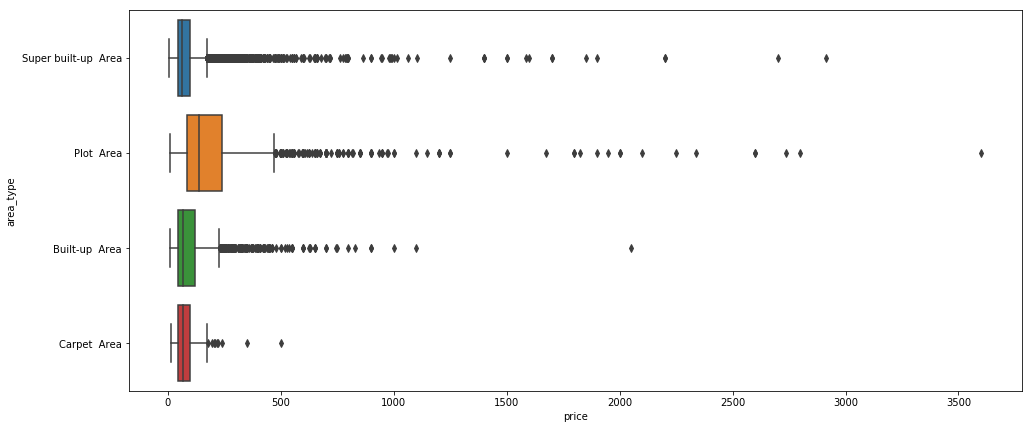

In [9]:
plt.figure(figsize=(16,7))
sns.boxplot(x=train_data['price'],y=train_data['area_type'])

As expected, the median cost for 'Plot Area' house type is the highest among other categories.

In [10]:
df.dtypes

area_type         object
availability      object
location          object
size              object
society           object
total_sqft        object
bath             float64
balcony          float64
price            float64
data_category     object
dtype: object

We can see that the two main columns 'size' and 'total_sqft' are objects instead of numeric. Hence, we cannot go further with EDA till we clean these columns. Let's do the cleaning and data exploration simultaneously. 

## Checking unique and number of unique values present in each categorical variable

In [11]:
for i in df.columns:
    if df[i].dtype == 'O':
        print('\nNumber of unique values in {} category: '.format(i), df[i].nunique())
        print('Unique data in {} category:\n'.format(i), df[i].unique())


Number of unique values in area_type category:  4
Unique data in area_type category:
 ['Super built-up  Area' 'Plot  Area' 'Built-up  Area' 'Carpet  Area']

Number of unique values in availability category:  82
Unique data in availability category:
 ['19-Dec' 'Ready To Move' '18-May' '18-Feb' '18-Nov' '20-Dec' '17-Oct'
 '21-Dec' '19-Sep' '20-Sep' '18-Mar' '20-Feb' '18-Apr' '20-Aug' '18-Oct'
 '19-Mar' '17-Sep' '18-Dec' '17-Aug' '19-Apr' '18-Jun' '22-Dec' '22-Jan'
 '18-Aug' '19-Jan' '17-Jul' '18-Jul' '21-Jun' '20-May' '19-Aug' '18-Sep'
 '17-May' '17-Jun' '21-May' '18-Jan' '20-Mar' '17-Dec' '16-Mar' '19-Jun'
 '22-Jun' '19-Jul' '21-Feb' 'Immediate Possession' '19-May' '17-Nov'
 '20-Oct' '20-Jun' '19-Feb' '21-Oct' '21-Jan' '17-Mar' '17-Apr' '22-May'
 '19-Oct' '21-Jul' '21-Nov' '21-Mar' '16-Dec' '22-Mar' '20-Jan' '21-Sep'
 '21-Aug' '14-Nov' '19-Nov' '15-Nov' '16-Jul' '15-Jun' '17-Feb' '20-Nov'
 '20-Jul' '16-Sep' '15-Oct' '15-Dec' '16-Oct' '22-Nov' '15-Aug' '17-Jan'
 '16-Nov' '20-Apr' '16-Ja

# Data Cleaning and Feature Engineering

## Size - Number of Bedrooms

In [12]:
df['size'].value_counts().head()

2 BHK        5739
3 BHK        4788
4 Bedroom     918
4 BHK         673
3 Bedroom     613
Name: size, dtype: int64

Since, number of bedrooms should be a continuos variable, we'll only extract the numeric value from this series of string values.

In [13]:
df['size'] = df['size'].apply(lambda x: x.split(' ')[0] if isinstance(x,str) else np.nan)
df['size'] = df['size'].astype(float)

In [14]:
df['size'].isnull().sum()

18

## Location

In [15]:
df['location'].value_counts()

Whitefield                               591
Sarjapur  Road                           437
Electronic City                          337
Kanakpura Road                           298
Thanisandra                              277
                                        ... 
Madanayakahalli                            1
Indranagar  100ft road defence colony      1
Rajagopala Nagar                           1
Old Town                                   1
RMC YARD                                   1
Name: location, Length: 1358, dtype: int64

We can see that, there are 1358 unique locations in this dataset. Looking closely at the dataset, most of these locations are repeated but with a slight change in name. Further, these locations may belong to the same area. Hence to clean this column, we are going group areas belonging to same pincodes together. To find the common pincodes for each of these locations we'll build a Web Scraper.

### Searching Location Pincode through Selenium Webdriver

In [16]:
uniq_locn=pd.DataFrame(df['location'].unique(), columns=['location'])

In [17]:
uniq_locn['browser_link'] = uniq_locn['location'].apply(lambda x: str(x) + " Bangalore site:codepin.in")

In [ ]:
import os
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException, WebDriverException
import requests

# get the path of ChromeDriverServer
dir = os.path.dirname(r"C:\Users\Devesh Singh\Python Scripts\Machine Hack\chromedriver.exe")
chrome_driver_path = dir + "\chromedriver.exe"

uniq_test = uniq_locn.copy(deep=True)

final_list=pd.DataFrame({'Place':[],
                         'Pin Code':[],
                         'Taluk':[],
                         'Division':[],
                         'District':[],
                         'State':[],
                        'Uniq':[]})

count=0
m=0
# create a new Chrome session
driver = webdriver.Chrome(chrome_driver_path)
driver.implicitly_wait(5)
driver.maximize_window()

for i in range(len(uniq_test)):
    
    # Navigate to the application home page
    driver.get("http://www.bing.com/")
    
    # get the search textbox
    #search_field = driver.find_element_by_name("q")    #worked, for Google.com only
    search_field = driver.find_element_by_id("sb_form_q")    #worked, for Bing Search
    
    # enter search keyword and submit
    search_field.send_keys(uniq_test.iloc[i,0])
    search_field.submit()
    
    try:
        #clicking the first link
        #driver.find_element(By.XPATH, '(//h3)[1]/a').click()    #worked, for Google.com only
        driver.find_element_by_partial_link_text("PIN CODE").click()   #worked, for Bing Search

        #waiting for link to open fully
        driver.implicitly_wait(5)

        #copying the url of the browser
        url = driver.current_url

        html = requests.get(url).content
        df_list = pd.read_html(html)


        df = df_list[-1]
        df2=pd.DataFrame(df.iloc[1,:])
        df3=pd.DataFrame.transpose(df2).reset_index(drop=True)
        value=pd.DataFrame({'Place':[df3.iloc[0,0]],
                            'Pin Code':[df3.iloc[0,1]],
                            'Taluk':[df3.iloc[0,2]],
                            'Division':[df3.iloc[0,3]],
                            'District':[df3.iloc[0,4]],
                            'State':[df3.iloc[0,5]],
                            'Uniq':[uniq_test.iloc[i,0]]})

        final_list=final_list.append(value, ignore_index=True)
        m+=1
        print(m,"  ",uniq_test.iloc[i,0])
    
    except (NoSuchElementException, WebDriverException) as e:
        count += 1
        pass
    driver.delete_all_cookies()
    
driver.close()

### Pincode File

Reading the dataframe of scraped pincodes.

In [18]:
# Downloaded list of pincodes
location_df = pd.read_excel(r'..\data\\additional_data\location_pincodes.xlsx')

In [19]:
uniq_locn['pincode'] = (uniq_locn['browser_link']
                        .map(dict(zip(location_df['browser_link'],location_df['pincode']))))

In [20]:
uniq_locn.head()

,location,browser_link,pincode
0,Electronic City Phase II,Electronic City Phase II Bangalore site:codepi...,560100
1,Chikka Tirupathi,Chikka Tirupathi Bangalore site:codepin.in,561203
2,Uttarahalli,Uttarahalli Bangalore site:codepin.in,560061
3,Lingadheeranahalli,Lingadheeranahalli Bangalore site:codepin.in,560091
4,Kothanur,Kothanur Bangalore site:codepin.in,560077


Mapping this list with original dataframe.

In [21]:
df['location'] = df['location'].map(dict(zip(uniq_locn['location'],uniq_locn['pincode'])))

In [22]:
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,data_category
0,Super built-up Area,19-Dec,560100,2.0,Coomee,1056,2.0,1.0,39.07,train
1,Plot Area,Ready To Move,561203,4.0,Theanmp,2600,5.0,3.0,120.00,train
2,Built-up Area,Ready To Move,560061,3.0,NaN,1440,2.0,3.0,62.00,train
3,Super built-up Area,Ready To Move,560091,3.0,Soiewre,1521,3.0,1.0,95.00,train
4,Super built-up Area,Ready To Move,560077,2.0,NaN,1200,2.0,1.0,51.00,train


In [23]:
df['location'].value_counts().head()

560100    914
560066    896
560077    631
560078    618
562125    484
Name: location, dtype: int64

In [24]:
df['location'].isnull().sum()

0

By grouping locations through pincodes we have reduced 1358 locations to 128 locations.

## Total Square Feet

In [25]:
df['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '3383', '5149', '6750'], dtype=object)

Since, there are multiple string values in this column, we are going to extract these string values and clean them. Since, this process is going to be of multiple step, we'll take only 'total_sqft' column into another dataframe.

In [26]:
sqft = df[['total_sqft']]

In [27]:
sqft.dtypes

total_sqft    object
dtype: object

### Extracting Only Float Val or Only String Val

Function to extract only float value, other values will be replaced as NaNs.

In [28]:
def float_val(x):
    try:
        x = float(x)
    except:
        x = np.nan
    return x

Function to extract only string value, other values will be replaced as NaNs.

In [29]:
def string_val(x):
    try:
        x = float(x)
        if isinstance(x,float):
            x = np.nan
    except:
        pass    
    return x

In [30]:
sqft['float_val'] = sqft['total_sqft'].apply(float_val)

sqft['string_val'] = sqft['total_sqft'].apply(string_val)

sqft[sqft['string_val'].notnull()].head(10)

,total_sqft,float_val,string_val
30,2100 - 2850,NaN,2100 - 2850
56,3010 - 3410,NaN,3010 - 3410
81,2957 - 3450,NaN,2957 - 3450
122,3067 - 8156,NaN,3067 - 8156
137,1042 - 1105,NaN,1042 - 1105
165,1145 - 1340,NaN,1145 - 1340
188,1015 - 1540,NaN,1015 - 1540
224,1520 - 1740,NaN,1520 - 1740
410,34.46Sq. Meter,NaN,34.46Sq. Meter
549,1195 - 1440,NaN,1195 - 1440


### Processing String Vals

The errorneous string values present in the 'total_sqft' column are of two types:
- Range, e.g. 2100 - 2850, to clean this types of error, we are going to take the average of these ranges
- Values in other unit, e.g. 34.46Sq. Meter, to clean this, we are going to extract the float and string values, convert this values in square feet.

In [31]:
sqft_string = sqft[['total_sqft','string_val']][sqft['string_val'].notnull()]

In [32]:
sqft_string['v_1'] = sqft_string['string_val'].apply(lambda x: x.split("-")[0])
sqft_string['v_2'] = sqft_string['string_val'].apply(lambda x: x.split("-")[-1])

In [33]:
def average_val(v_1, v_2):
    try:
        v_1 = float(v_1)
        v_2 = float(v_2)
        avg = (v_1 + v_2)/2
    except:
        avg = v_1
    return avg

In [34]:
sqft_string['avg_val'] = sqft_string.apply(lambda x: average_val(x.v_1,x.v_2),axis=1 )
sqft_string.head()

,total_sqft,string_val,v_1,v_2,avg_val
30,2100 - 2850,2100 - 2850,2100,2850,2475
56,3010 - 3410,3010 - 3410,3010,3410,3210
81,2957 - 3450,2957 - 3450,2957,3450,3203.5
122,3067 - 8156,3067 - 8156,3067,8156,5611.5
137,1042 - 1105,1042 - 1105,1042,1105,1073.5


In [35]:
sqft_string['conversion'] = sqft_string['avg_val'].apply(string_val)

sqft_string.head(10)

,total_sqft,string_val,v_1,v_2,avg_val,conversion
30,2100 - 2850,2100 - 2850,2100,2850,2475,NaN
56,3010 - 3410,3010 - 3410,3010,3410,3210,NaN
81,2957 - 3450,2957 - 3450,2957,3450,3203.5,NaN
122,3067 - 8156,3067 - 8156,3067,8156,5611.5,NaN
137,1042 - 1105,1042 - 1105,1042,1105,1073.5,NaN
165,1145 - 1340,1145 - 1340,1145,1340,1242.5,NaN
188,1015 - 1540,1015 - 1540,1015,1540,1277.5,NaN
224,1520 - 1740,1520 - 1740,1520,1740,1630,NaN
410,34.46Sq. Meter,34.46Sq. Meter,34.46Sq. Meter,34.46Sq. Meter,34.46Sq. Meter,34.46Sq. Meter
549,1195 - 1440,1195 - 1440,1195,1440,1317.5,NaN


### Extracting Conversion Units with 'Re'

In [36]:
import re
sqft_string['con_val'] = sqft_string['conversion'].apply(lambda x: "".join(re.findall(r"[a-zA-Z_]", str(x))))

sqft_string['num_val'] = sqft_string['conversion'].apply(lambda x: ".".join(re.findall("\d+", str(x))))

In [37]:
sqft_string.head(13)

,total_sqft,string_val,v_1,v_2,avg_val,conversion,con_val,num_val
30,2100 - 2850,2100 - 2850,2100,2850,2475,NaN,nan,
56,3010 - 3410,3010 - 3410,3010,3410,3210,NaN,nan,
81,2957 - 3450,2957 - 3450,2957,3450,3203.5,NaN,nan,
122,3067 - 8156,3067 - 8156,3067,8156,5611.5,NaN,nan,
137,1042 - 1105,1042 - 1105,1042,1105,1073.5,NaN,nan,
165,1145 - 1340,1145 - 1340,1145,1340,1242.5,NaN,nan,
188,1015 - 1540,1015 - 1540,1015,1540,1277.5,NaN,nan,
224,1520 - 1740,1520 - 1740,1520,1740,1630,NaN,nan,
410,34.46Sq. Meter,34.46Sq. Meter,34.46Sq. Meter,34.46Sq. Meter,34.46Sq. Meter,34.46Sq. Meter,SqMeter,34.46
549,1195 - 1440,1195 - 1440,1195,1440,1317.5,NaN,nan,


In [38]:
sqft_string['num_val'] = sqft_string['num_val'].replace('', np.nan).fillna(0).astype(float)

In [39]:
sqft_string['num_val'] = np.where(sqft_string['num_val'] == 0,
                                  sqft_string['avg_val'],
                                  sqft_string['num_val'])

In [40]:
sqft_string.head(14)

,total_sqft,string_val,v_1,v_2,avg_val,conversion,con_val,num_val
30,2100 - 2850,2100 - 2850,2100,2850,2475,NaN,nan,2475
56,3010 - 3410,3010 - 3410,3010,3410,3210,NaN,nan,3210
81,2957 - 3450,2957 - 3450,2957,3450,3203.5,NaN,nan,3203.5
122,3067 - 8156,3067 - 8156,3067,8156,5611.5,NaN,nan,5611.5
137,1042 - 1105,1042 - 1105,1042,1105,1073.5,NaN,nan,1073.5
165,1145 - 1340,1145 - 1340,1145,1340,1242.5,NaN,nan,1242.5
188,1015 - 1540,1015 - 1540,1015,1540,1277.5,NaN,nan,1277.5
224,1520 - 1740,1520 - 1740,1520,1740,1630,NaN,nan,1630
410,34.46Sq. Meter,34.46Sq. Meter,34.46Sq. Meter,34.46Sq. Meter,34.46Sq. Meter,34.46Sq. Meter,SqMeter,34.46
549,1195 - 1440,1195 - 1440,1195,1440,1317.5,NaN,nan,1317.5


### Loading Conversion Factor

In [41]:
# The list of conversion factor
conversion_factor = pd.read_csv(r"..\data\additional_data\conversion_factor.csv")

In [42]:
conversion_factor

,unit,conversion_factor
0,Acres,43560.0000
1,SqMeter,10.7639
2,SqYards,9.0000
3,Cents,435.6000
4,Grounds,2400.0000
5,Guntha,1089.0000
6,Perch,272.2500


Mapping the conversion factor and filling remaining values with 1.

In [43]:
sqft_string['conversion_factor'] = (sqft_string['con_val']
                                           .map(dict(zip(conversion_factor['unit']
                                                         ,conversion_factor['conversion_factor']))).fillna(1))

In [44]:
sqft_string['after_conversion'] = sqft_string['num_val']*sqft_string['conversion_factor']

sqft_string['after_conversion'] = sqft_string['after_conversion'].apply(lambda x: round(x, 2))

sqft_string.head(10)

,total_sqft,string_val,v_1,v_2,avg_val,conversion,con_val,num_val,conversion_factor,after_conversion
30,2100 - 2850,2100 - 2850,2100,2850,2475,NaN,nan,2475,1.0000,2475.00
56,3010 - 3410,3010 - 3410,3010,3410,3210,NaN,nan,3210,1.0000,3210.00
81,2957 - 3450,2957 - 3450,2957,3450,3203.5,NaN,nan,3203.5,1.0000,3203.50
122,3067 - 8156,3067 - 8156,3067,8156,5611.5,NaN,nan,5611.5,1.0000,5611.50
137,1042 - 1105,1042 - 1105,1042,1105,1073.5,NaN,nan,1073.5,1.0000,1073.50
165,1145 - 1340,1145 - 1340,1145,1340,1242.5,NaN,nan,1242.5,1.0000,1242.50
188,1015 - 1540,1015 - 1540,1015,1540,1277.5,NaN,nan,1277.5,1.0000,1277.50
224,1520 - 1740,1520 - 1740,1520,1740,1630,NaN,nan,1630,1.0000,1630.00
410,34.46Sq. Meter,34.46Sq. Meter,34.46Sq. Meter,34.46Sq. Meter,34.46Sq. Meter,34.46Sq. Meter,SqMeter,34.46,10.7639,370.92
549,1195 - 1440,1195 - 1440,1195,1440,1317.5,NaN,nan,1317.5,1.0000,1317.50


In [45]:
string_val_dict = dict(zip(sqft_string['total_sqft'],sqft_string['after_conversion']))

### Mapping Converted Rates with Original DF

In [46]:
df['total_sqft_new'] = df['total_sqft'].map(string_val_dict)

In [47]:
df['total_sqft'] = (df.apply(lambda row: row['total_sqft'] 
                             if np.isnan(row['total_sqft_new']) 
                             else row['total_sqft_new'],axis=1))

In [48]:
df['total_sqft'] = df['total_sqft'].astype(float)

df.drop(['total_sqft_new'], axis=1, inplace=True)

In [49]:
df['total_sqft'].isnull().sum()

0

## Society

In [50]:
df['society'].isnull().sum()

6128

In [51]:
df[df['society'].isnull()].head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,data_category
2,Built-up Area,Ready To Move,560061,3.0,NaN,1440.0,2.0,3.0,62.00,train
4,Super built-up Area,Ready To Move,560077,2.0,NaN,1200.0,2.0,1.0,51.00,train
8,Super built-up Area,Ready To Move,560037,3.0,NaN,1310.0,3.0,1.0,63.25,train
9,Plot Area,Ready To Move,560004,6.0,NaN,1020.0,6.0,NaN,370.00,train
10,Super built-up Area,18-Feb,560066,3.0,NaN,1800.0,2.0,2.0,70.00,train


Here, just making a binary classification whether the House is in a Society or not, filling NaNs with zero and remaining with 1.

In [52]:
df.loc[(df['society'].isnull()), 'society']= 0

df.loc[(df['society']!=0),'society'] = 1

df['society'].value_counts()

1    8672
0    6128
Name: society, dtype: int64

## Availability

In [53]:
df['availability'].value_counts().head()

Ready To Move    11743
18-Dec             351
18-May             324
18-Apr             296
18-Aug             225
Name: availability, dtype: int64

In 'availability' column, we can broadly categorised the data into two ways:
- "Ready To Move" or "Immediate Possession"
- A future date

Since, the year is not mentioned in these dates, hence we cannot utilise this column further.
Therefore, categorising the data points as '1' for "Ready To Move" or "Immediate Possession" and 
'0' for the dates.

In [54]:
df['availability'].replace(["Ready To Move","Immediate Possession"], 1, inplace=True)

df.loc[(df['availability']!=1),'availability'] = 0

df['availability'].value_counts()

1    11761
0     3039
Name: availability, dtype: int64

# Imputation

In [55]:
df.isnull().sum()

area_type           0
availability        0
location            0
size               18
society             0
total_sqft          0
bath               80
balcony           678
price            1480
data_category       0
dtype: int64

## Size

In [56]:
df[df['size'].isna()].head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,data_category
579,Plot Area,1,562125,NaN,1,1800.0,NaN,NaN,34.185,train
1775,Plot Area,1,562110,NaN,1,3817.0,NaN,NaN,124.000,train
2264,Plot Area,1,560050,NaN,0,2400.0,NaN,NaN,460.000,train
2809,Plot Area,1,562125,NaN,1,1800.0,NaN,NaN,28.785,train
2862,Plot Area,1,562110,NaN,1,1950.0,NaN,NaN,46.800,train


To impute variable 'size' i.e. number of bedrooms, the variable 'total_sqft' is used. The 'total_sqft' is divided by 550(considering a generic factor per room in a house with hall and kitchen), and the roundup till the next integer.

In [57]:
df['size'] = df['size'].astype(float)

In [58]:
df['size'] = df.apply(lambda row: math.ceil(float(row['total_sqft']/550)) if np.isnan(row['size']) else row['size'], axis=1)

In [59]:
df[df['size'].isna()]

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,data_category


## Bath

In [60]:
df[df['bath'].isna()].head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,data_category
56,Built-up Area,0,562110,4.0,1,3210.0,NaN,NaN,192.000,train
81,Built-up Area,0,560077,4.0,1,3203.5,NaN,NaN,224.500,train
224,Super built-up Area,0,562110,3.0,1,1630.0,NaN,NaN,74.820,train
344,Super built-up Area,0,560062,1.0,1,525.0,NaN,NaN,21.530,train
579,Plot Area,1,562125,4.0,1,1800.0,NaN,NaN,34.185,train


In [61]:
df[['size','bath']].corr()

,size,bath
size,1.000000,0.897959
bath,0.897959,1.000000


As we can see that number of bedrooms and bathrooms are highly correlated, we will fill the NaNs in variable 'bath' with values of variable 'size'.

In [62]:
df['bath'] = df.apply(lambda row: row['size'] if np.isnan(row['bath']) else row['bath'], axis=1)

## Balcony

In [63]:
df.groupby(['size']).agg({'balcony':['count','mean','median']})

balcony                 
       count      mean median
size                         
1.0      720  0.768056    1.0
2.0     6053  1.429704    1.0
3.0     5177  1.815723    2.0
4.0     1393  1.701364    2.0
5.0      335  1.665672    2.0
6.0      211  1.800948    2.0
7.0       97  1.917526    2.0
8.0       79  1.734177    2.0
9.0       44  1.909091    2.0
10.0       5  2.600000    3.0
11.0       3  2.000000    3.0
12.0       1  2.000000    2.0
13.0       1  0.000000    0.0
14.0       1  0.000000    0.0
16.0       0       NaN    NaN
18.0       0       NaN    NaN
19.0       0       NaN    NaN
27.0       1  0.000000    0.0
43.0       1  0.000000    0.0

Looking at the mean and median of number of balconies grouped by number of bedrooms. We can infer, in general, that 2 or less than 2 bedrooms house has 1 balcony,  3 to 9 bedrooms house has 2 balconies, more than 9 bedrooms house has 3 or more balconies. We can impute these values with median, and for rooms where median is not available(16 to 19 rooms), filling NaNs with 4.

In [64]:
balcony = df.groupby(['size']).agg({'balcony':'median'}).reset_index()

balcony['balcony'].fillna(4, inplace=True)

balcony_dict = dict(zip(balcony['size'], balcony['balcony']))

df['new_balcony'] = df[df['balcony'].isna()]['size'].map(balcony_dict)

In [65]:
df['balcony'] = (df.apply(lambda row: row['new_balcony'] 
                          if np.isnan(row['balcony']) 
                          else row['balcony'], axis=1))

In [66]:
df.drop(['new_balcony'], axis=1, inplace=True)

In [67]:
df['balcony'].isnull().sum()

0

# Outlier Removal

Checking the outliers in the training dataset and removing them from it. Removing outliers from 'total_sqft' first so it doesn't create any skewness in next step deriving any new feature.

For this operation, splitting the data based on train and test and joining it back later.

In [68]:
train_df = df[df['data_category']=='train']
test_df = df[df['data_category']=='test']

<Figure size 2160x720 with 0 Axes>

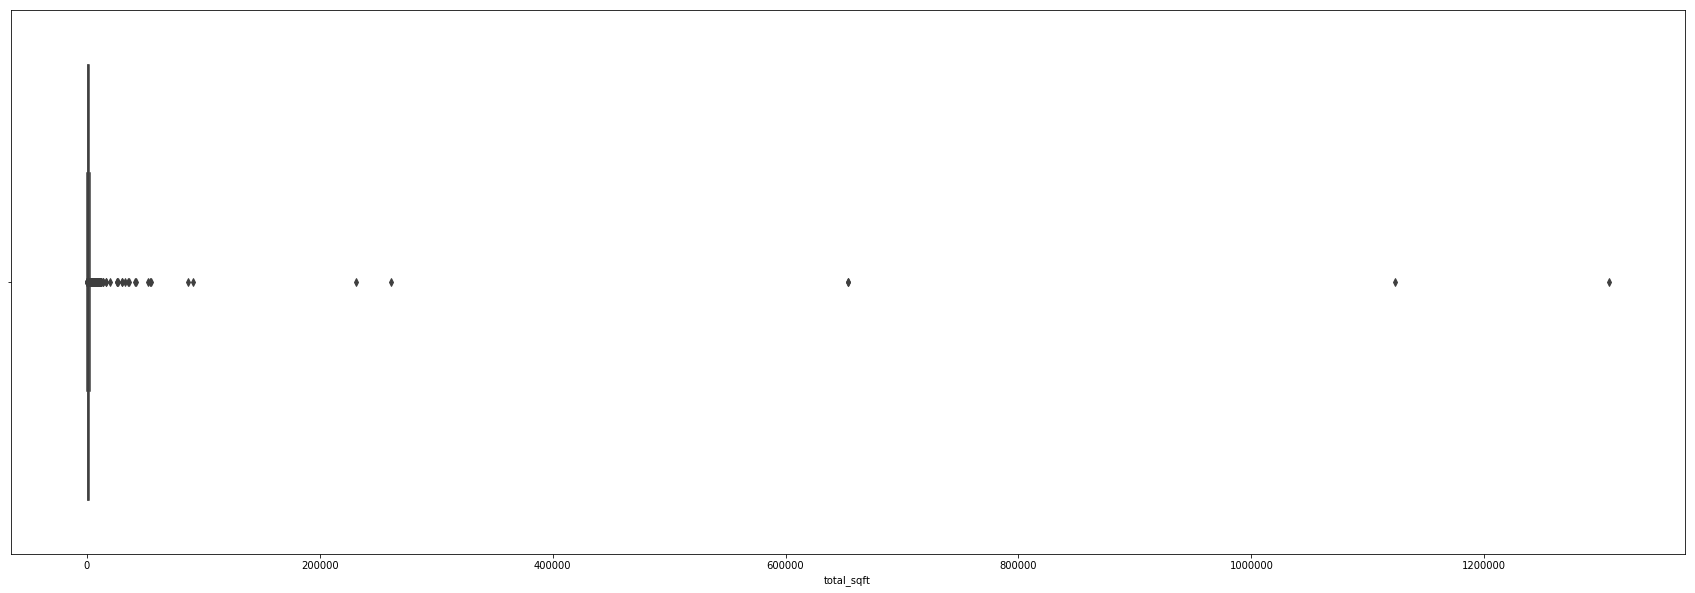

In [69]:
plt.figure(figsize=(30,10))
sns.boxplot(train_df['total_sqft'])
plt.show()

We can see that there are some outliers which are exobitant, hence we need to remove them. Setting a lower and upper limit to remove these outliers.

In [70]:
lower_limit = np.nanpercentile(train_df['total_sqft'],0.25)
upper_limit = np.nanpercentile(train_df['total_sqft'],99.75)
print(lower_limit)
print(upper_limit)

400.0
11000.0


In [71]:
len(train_df)

13320

In [72]:
train_df = train_df[train_df['total_sqft'].between(lower_limit, upper_limit)]

In [73]:
len(train_df)

13256

So, we have removed 64 data points from training dataset.

In [74]:
df = pd.concat([train_df,test_df])

# Deriving New Feature

Pincodes, a categorical variable, with 128 distinct values will increase the number of columns with one-hot encoding. This will also increase the overall computational time for training the model. To solve this issue, we can optimise the model with a new numeric feature derived from 'location', 'area_type','society' and drop 'location' from the dataset later.

This new feature will be derived from 'Training Data' only and will be common for both training and test data.

## Price Per Location - Combining Location, Society and Area Type

In [75]:
price_per_loc = (df[df['data_category']=='train'].groupby(['area_type','location','society'])
                 .agg({'total_sqft': 'sum','price':'sum'}).reset_index())

price_per_loc['avg_price_per_loc'] = price_per_loc['price']/price_per_loc['total_sqft']

In [76]:
price_per_loc.head()

,area_type,location,society,total_sqft,price,avg_price_per_loc
0,Built-up Area,0,0,3420.0,410.0,0.119883
1,Built-up Area,0,1,1130.0,68.0,0.060177
2,Built-up Area,560001,0,4970.0,515.0,0.103622
3,Built-up Area,560001,1,1000.0,50.0,0.050000
4,Built-up Area,560003,0,11300.0,2410.0,0.213274


Merging this new column with original 'df'.

In [77]:
df = pd.merge(df,price_per_loc[['area_type','location', 'society','avg_price_per_loc']],
                  on=['area_type','location', 'society'], how='left')

In [78]:
df['avg_price_per_loc'].isnull().sum()

13

## Price Per Location 2 - Combining Location and Society Only 

Since, there are 13 values in Test Data that not available to merge, we can create another variable 'avg_price_per_loc_2' from 'location' and 'society' only to fill NaNs.

In [79]:
price_per_loc_2 = (df[df['data_category']=='train'].groupby(['location','society'])
                   .agg({'total_sqft': 'sum','price':'sum'}).reset_index())

price_per_loc_2['avg_price_per_loc_2'] = price_per_loc_2['price']/price_per_loc_2['total_sqft']

In [80]:
price_per_loc_2.head()

,location,society,total_sqft,price,avg_price_per_loc_2
0,0,0,16173.82,1774.84,0.109735
1,0,1,4734.00,229.00,0.048373
2,560001,0,32275.00,5385.00,0.166847
3,560001,1,8914.00,1610.00,0.180615
4,560003,0,54775.00,10588.80,0.193314


In [81]:
df = pd.merge(df,price_per_loc_2[['location', 'society','avg_price_per_loc_2']],
                  on=['location', 'society'], how='left')

In [82]:
df['avg_price_per_loc'] = df.apply(lambda row: row['avg_price_per_loc_2'] if np.isnan(row['avg_price_per_loc']) else row['avg_price_per_loc'], axis=1)

In [83]:
df['avg_price_per_loc'].isnull().sum()

3

## Price Per Location 3 - Average Price per SqFt for remaining null values

There are still three values we need to fill.

In [84]:
average_price = df[df['data_category']=='train']['price'].sum()/df[df['data_category']=='train']['total_sqft'].sum()

In [85]:
df['avg_price_per_loc'].fillna(average_price, inplace=True)

<Figure size 2160x720 with 0 Axes>

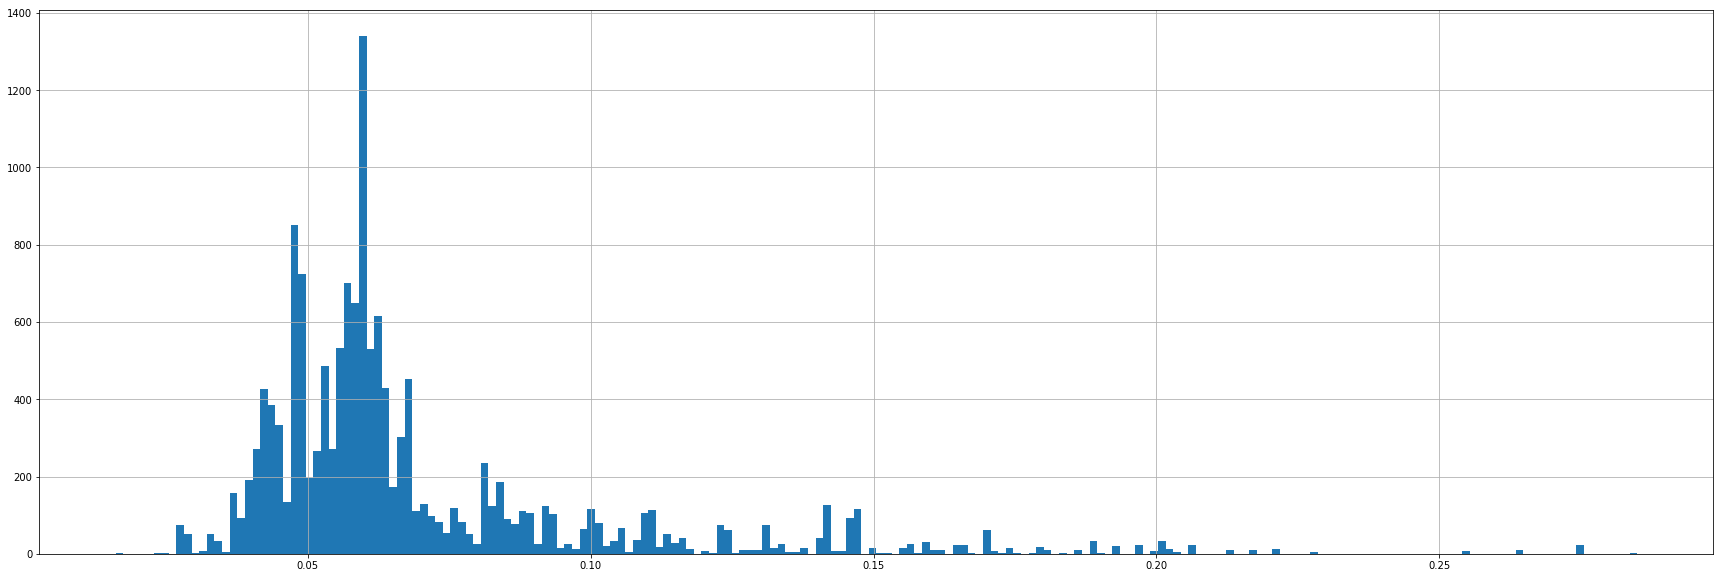

In [86]:
plt.figure(figsize=(30,10))
df['avg_price_per_loc'].hist(bins=200)
plt.show()

In [87]:
df.drop(['location','avg_price_per_loc_2'],axis=1, inplace=True)

In [88]:
df.head(5)

,area_type,availability,size,society,total_sqft,bath,balcony,price,data_category,avg_price_per_loc
0,Super built-up Area,0,2.0,1,1056.0,2.0,1.0,39.07,train,0.047765
1,Plot Area,1,4.0,1,2600.0,5.0,3.0,120.00,train,0.047257
2,Built-up Area,1,3.0,0,1440.0,2.0,3.0,62.00,train,0.048929
3,Super built-up Area,1,3.0,1,1521.0,3.0,1.0,95.00,train,0.075807
4,Super built-up Area,1,2.0,0,1200.0,2.0,1.0,51.00,train,0.048198


Finally we have got a new feature which is created from variable 'location'.

# Checking the Distribution

## Specifying data type to each variable

In [89]:
df['area_type'] = pd.Categorical(df['area_type'])
df[['size','total_sqft','bath','balcony','avg_price_per_loc','price']] = df[['size','total_sqft','bath','balcony','avg_price_per_loc','price']].apply(pd.to_numeric)

df[['availability','society']]  = df[['availability','society']].astype(int)

In [90]:
df = df[['area_type', 'availability', 'size', 'society', 'total_sqft', 'bath',
       'balcony', 'avg_price_per_loc', 'price', 'data_category']]

In [91]:
df.head()

,area_type,availability,size,society,total_sqft,bath,balcony,avg_price_per_loc,price,data_category
0,Super built-up Area,0,2.0,1,1056.0,2.0,1.0,0.047765,39.07,train
1,Plot Area,1,4.0,1,2600.0,5.0,3.0,0.047257,120.00,train
2,Built-up Area,1,3.0,0,1440.0,2.0,3.0,0.048929,62.00,train
3,Super built-up Area,1,3.0,1,1521.0,3.0,1.0,0.075807,95.00,train
4,Super built-up Area,1,2.0,0,1200.0,2.0,1.0,0.048198,51.00,train


## Total Sqft

<Figure size 2160x720 with 0 Axes>

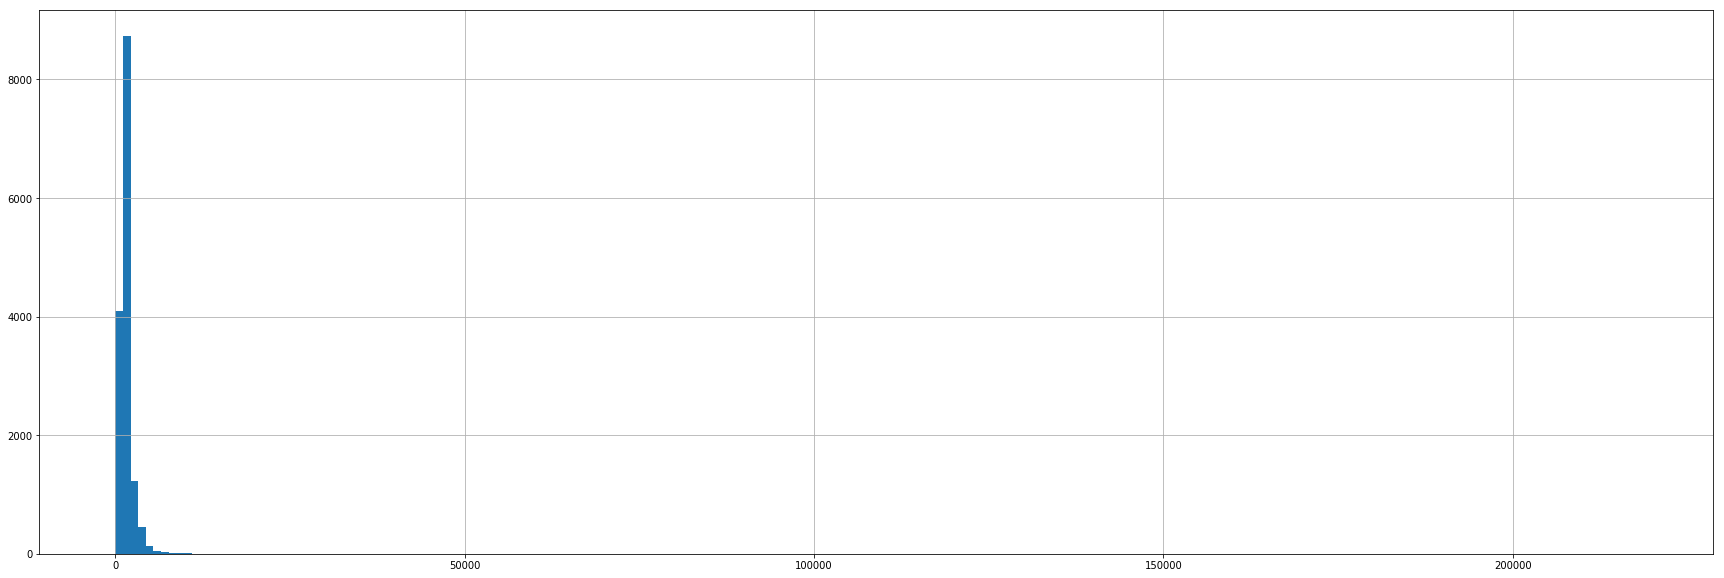

In [92]:
plt.figure(figsize=(30,10))
df['total_sqft'].hist(bins=200)
plt.show()

The distribution is right skewed. Let's see if taking logrithmic value can remove this skewness.

<Figure size 2160x720 with 0 Axes>

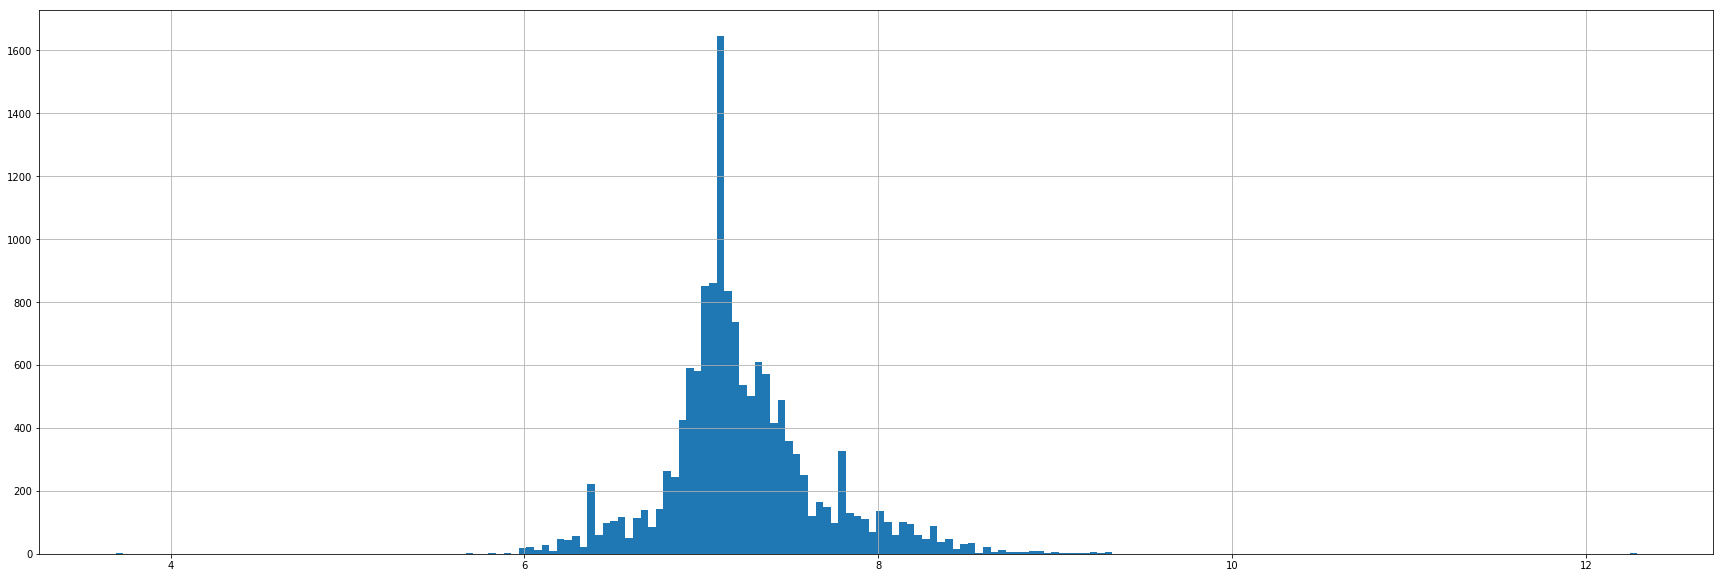

In [93]:
plt.figure(figsize=(30,10))
np.log(df['total_sqft']).hist(bins=200)
plt.show()

Perfect. The skewness has decreased significantly with logrithmic conversion.

In [94]:
df['total_sqft'] = np.log(df['total_sqft'])

## Price

Splitting the data to check for 'price' variable distribution.

In [95]:
train_df = df[df['data_category']=='train']
train_df.drop(['data_category'], axis=1, inplace=True)
len(train_df)

13256

In [96]:
test_df = df[df['data_category']=='test']
test_df.drop(['data_category'], axis=1, inplace=True)
len(test_df)

1480

<Figure size 2160x720 with 0 Axes>

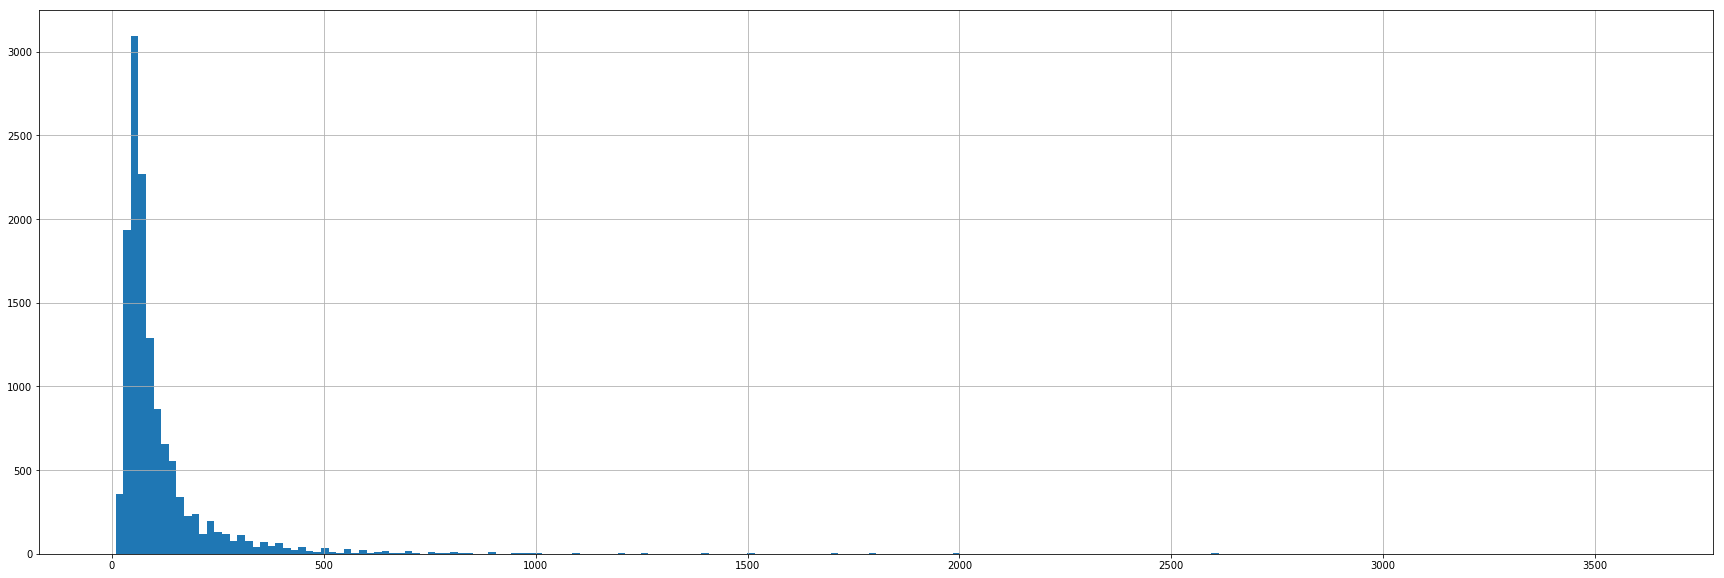

In [97]:
plt.figure(figsize=(30,10))
(train_df['price']).hist(bins=200)
plt.show()

Here also, the distribution is right skewed.

<Figure size 2160x720 with 0 Axes>

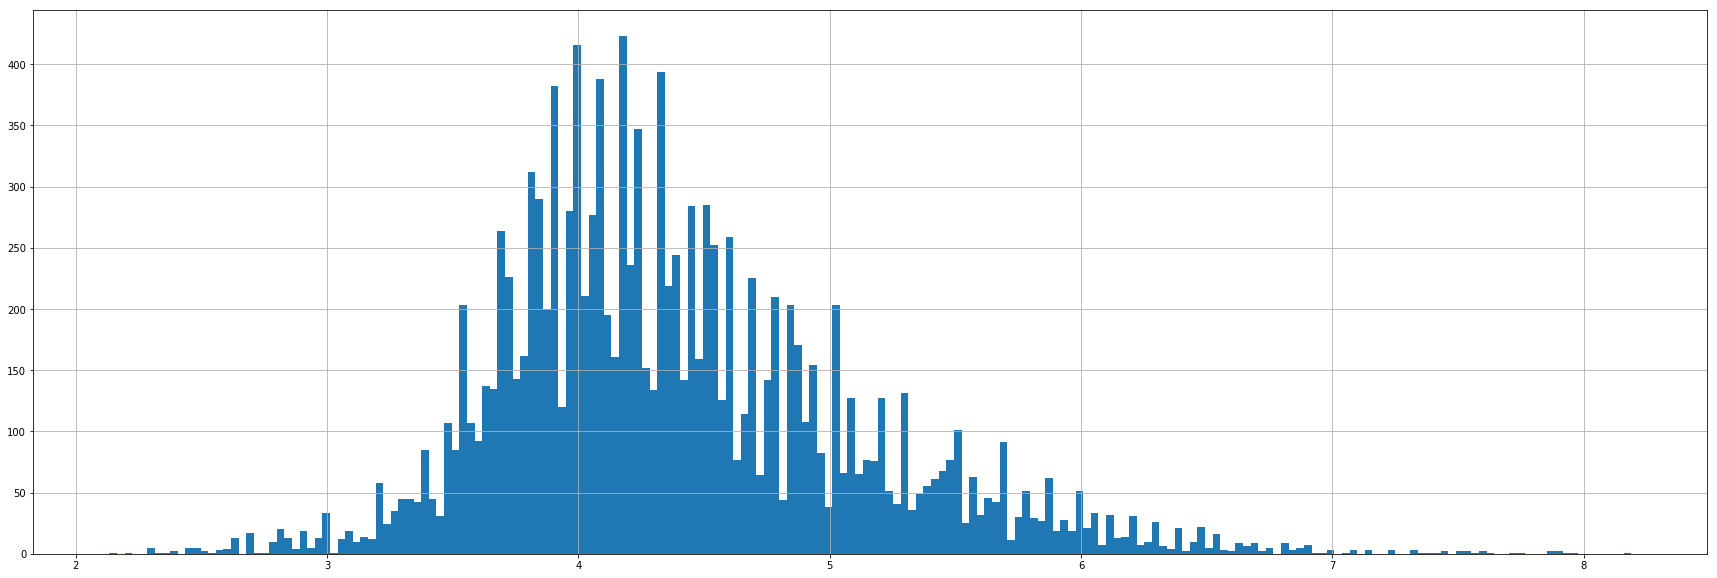

In [98]:
plt.figure(figsize=(30,10))
np.log(train_df['price']).hist(bins=200)
plt.show()

In [99]:
train_df['price'] = np.log(train_df['price'])

In [100]:
train_df.dtypes

area_type            category
availability            int32
size                  float64
society                 int32
total_sqft            float64
bath                  float64
balcony               float64
avg_price_per_loc     float64
price                 float64
dtype: object

# One-Hot Encoding

In [101]:
main_train = pd.get_dummies(train_df)
main_test = pd.get_dummies(test_df)

In [102]:
main_train.head(3)

main_test.head(3)

,availability,size,society,total_sqft,bath,balcony,avg_price_per_loc,price,area_type_Built-up Area,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area
0,0,2.0,1,6.962243,2.0,1.0,0.047765,3.665355,0,0,0,1
1,1,4.0,1,7.863267,5.0,3.0,0.047257,4.787492,0,0,1,0
2,1,3.0,0,7.272398,2.0,3.0,0.048929,4.127134,1,0,0,0


,availability,size,society,total_sqft,bath,balcony,avg_price_per_loc,price,area_type_Built-up Area,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area
13256,1,2.0,1,7.110696,2.0,2.0,0.060125,NaN,0,0,0,1
13257,1,9.0,0,7.783224,9.0,2.0,0.091662,NaN,0,0,1,0
13258,0,4.0,1,7.408531,5.0,2.0,0.100931,NaN,0,0,1,0


Saving file post-processing.

In [103]:
main_train.to_csv('../data/processed/train_df.csv', index=False)
main_test.to_csv('../data/processed/test_df.csv', index=False)

# Modeling

## Import Models

In [104]:
# Accuracy and Cross-Validation scores.
#Import models from scikit learn module:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score   #For K-fold cross validation
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import datasets, linear_model, metrics
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, make_scorer
from math import sqrt
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"

import warnings
warnings.filterwarnings('ignore')

C:\Users\dev26\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [105]:
#read it back
main_train=pd.read_csv("../data/processed/train_df.csv")
main_test=pd.read_csv("../data/processed/test_df.csv")

In [106]:
X = main_train.drop('price', axis=1)
Y = main_train['price']

## Train-Test Split

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(10604, 11) (10604,)
(2652, 11) (2652,)


## Creating Custom Metric Function

In [108]:
#Generic function for making a classification model and accessing performance:
## How to create your own metric function and make it as a scorer object

def mean_sq_error(y,y_pred):
    return sqrt(mean_squared_error(y,y_pred=y_pred))

rmse = make_scorer(mean_sq_error)


def regression_model(model, data, predictors, outcome):
    scores = cross_val_score(model, data[predictors],data[outcome],cv=5,scoring=rmse)
    for i in range(len(scores)):
        print("CV %s"%i + " Score:%s"%"{0:.5}".format(scores[i]) )
        
    print ("Average RMSE Cross-Validation Score : %s" % "{0:.3}".format(np.mean(scores)))

## Fitting Models

In [109]:
all_variable=list(main_train)
all_variable.remove('price')

### Decision Tree

In [110]:
# DecisionTreeRegressor
outcome_var = 'price'
model = DecisionTreeRegressor()
predictor_var = all_variable
regression_model(model, main_train, predictor_var, outcome_var)

CV 0 Score:0.37814
CV 1 Score:0.39588
CV 2 Score:0.39716
CV 3 Score:0.38858
CV 4 Score:0.37449
Average RMSE Cross-Validation Score : 0.387


### Random Forest

In [111]:
# Random Forest Regression
outcome_var = 'price'
model = RandomForestRegressor(n_estimators=200, random_state=0, n_jobs = -1)
predictor_var = all_variable
regression_model(model, main_train, predictor_var, outcome_var)

CV 0 Score:0.28972
CV 1 Score:0.29582
CV 2 Score:0.30658
CV 3 Score:0.29819
CV 4 Score:0.29095
Average RMSE Cross-Validation Score : 0.296


### XGBoost

In [112]:
# XGBoost Regressor
outcome_var = 'price'
model = XGBRegressor(n_estimators=540,random_state=0,n_jobs=-1)
predictor_var = all_variable
regression_model(model, main_train, predictor_var, outcome_var)

[09:54:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:54:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:54:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:54:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:54:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CV 0 Score:0.2892
CV 1 Score:0.29383
CV 2 Score:0.30917
CV 3 Score:0.30554
CV 4 Score:0.2946
Average RMSE Cross-Validation Score : 0.298


### LGBM

In [113]:
# LGBM Regressor
outcome_var = 'price'
model = LGBMRegressor(n_estimators=500)
predictor_var = all_variable
regression_model(model, main_train, predictor_var, outcome_var)

CV 0 Score:0.28578
CV 1 Score:0.29397
CV 2 Score:0.30762
CV 3 Score:0.2996
CV 4 Score:0.28896
Average RMSE Cross-Validation Score : 0.295


We can see that all the ensemble models are giving similar cross validation score of ~0.29 without much hyper parameter tuning.

## Hyper Parameter Tuning

### Randomised Search

In [114]:
from sklearn.model_selection import RandomizedSearchCV

In [115]:
# Number of trees in random forest
n_estimators = list(np.arange(160,400,100))

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 80, num = 5)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

In [116]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [117]:
random_grid

{'n_estimators': [160, 260, 360],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 27, 45, 62, 80, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [118]:
import time
start = time.clock()

# Use the random grid to search for best hyperparameters
# First create the base model to tune

rf1 = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf1,
                               param_distributions=random_grid,
                               n_iter=33,
                               cv=3,
                               verbose=5,
                               random_state=0,
                               n_jobs=-1,
                               scoring="neg_mean_squared_error")

# Fit the random search model
rf_random.fit(X, Y)

end = time.clock()
end - start

Fitting 3 folds for each of 33 candidates, totalling 99 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  3.4min finished


209.6670045

In [119]:
# Random Forest Regression
outcome_var = 'price'
model = rf_random.best_estimator_
predictor_var = all_variable
regression_model(model, main_train, predictor_var, outcome_var)

CV 0 Score:0.27769
CV 1 Score:0.2857
CV 2 Score:0.30269
CV 3 Score:0.29342
CV 4 Score:0.29017
Average RMSE Cross-Validation Score : 0.29


In [120]:
rf1_main=rf_random.best_estimator_
rf1_main.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=27,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=260, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [121]:
predictions=rf1_main.predict(X_test)

print(np.sqrt(metrics.mean_squared_error(y_test,predictions)))

0.2921994409239012


In [143]:
estimators = np.arange(200, 930, 40) #850 #880

model=RandomForestRegressor()

rmse_scores = []
for n in estimators:
    model.set_params(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=n, n_jobs=-1,
           oob_score=False, random_state=None, warm_start=False)
    model.fit(X_train, y_train)
    predictions=model.predict(X_test)
    rmse_scores.append(np.sqrt(metrics.mean_squared_error(y_test,predictions)))

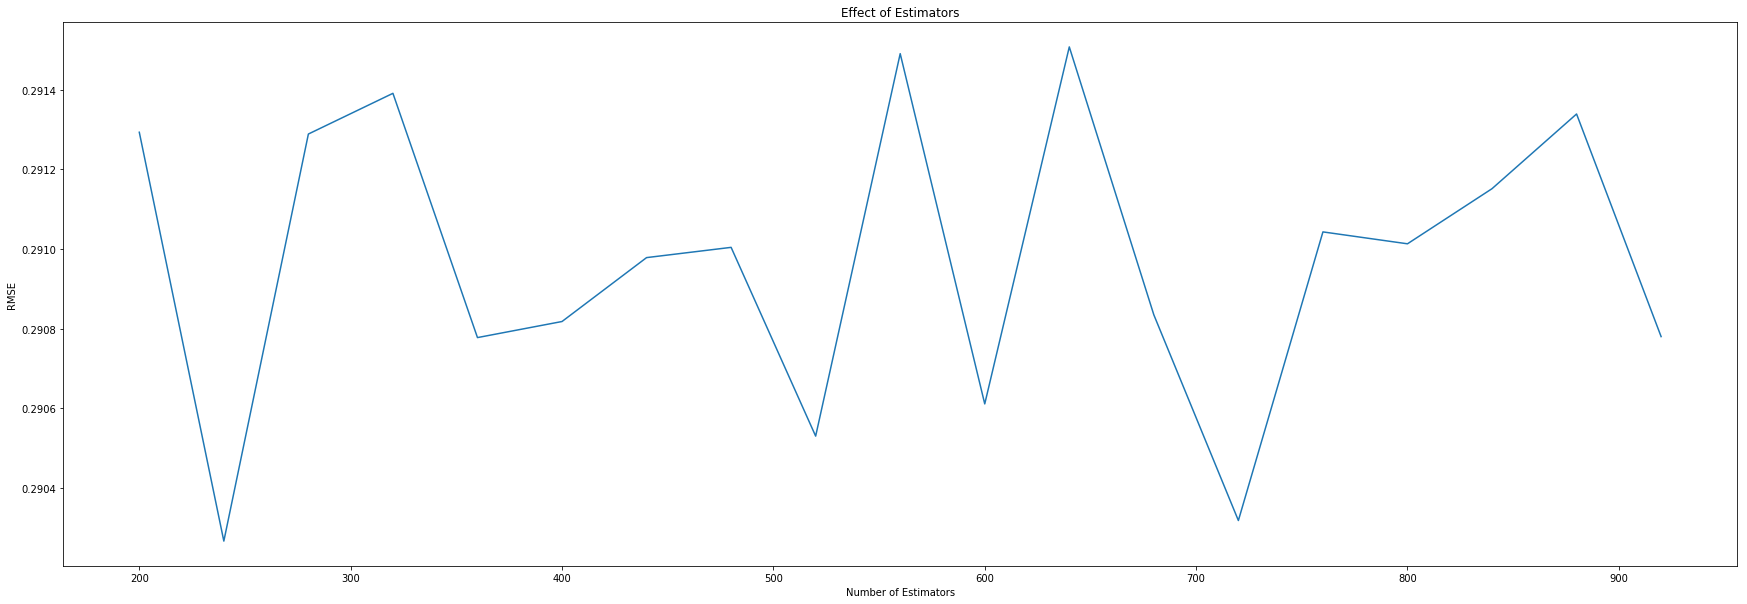

In [142]:
plt.figure(figsize=(30,10))
plt.title("Effect of Estimators")
plt.xlabel("Number of Estimators")
plt.ylabel("RMSE")
plt.plot(estimators, rmse_scores)

### Grid Search

In [122]:
from sklearn.model_selection import GridSearchCV

In [123]:
XG_grid = {"learning_rate":[0.01,0.05,0.1],
           "n_estimators":[600],
           "silent":[True],
           "n_jobs":[-1],
           "min_child_weight":[1,3],
           "max_depth":[4,6],
           "booster":['gbtree'],
           "gamma":[0.01,0.1],
           "colsample_bytree":[0.8],
          "subsample":[0.75,0.85]}

In [124]:
import time
start = time.clock()


XG=XGBRegressor()

XG_Boost = GridSearchCV(estimator=XG,
                        param_grid=XG_grid,
                        n_jobs=-1,
                        cv=4,
                        scoring="neg_mean_squared_error",
                        verbose=5)


XG_Boost.fit(X,Y)

end = time.clock()
end - start

Fitting 4 folds for each of 48 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed: 11.2min finished


680.8390551

In [125]:
# cv_results = XG_Boost.cv_results_
# for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
#     print(np.sqrt(-mean_score), params)

In [126]:
# XGBoost Regression
rmse = make_scorer(mean_sq_error,greater_is_better=True)
outcome_var = 'price'
model = XG_Boost.best_estimator_
predictor_var = all_variable
regression_model(model, main_train, predictor_var, outcome_var)

CV 0 Score:0.28537
CV 1 Score:0.29053
CV 2 Score:0.30411
CV 3 Score:0.29754
CV 4 Score:0.28717
Average RMSE Cross-Validation Score : 0.293


In [127]:
# XG_Boost1=XG_Boost.best_estimator_
XG_Boost1 = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                           colsample_bynode=1, colsample_bytree=0.8, gamma=0.01,
                           importance_type='gain', learning_rate=0.05, max_delta_step=0,
                           max_depth=6, min_child_weight=1, missing=None, n_estimators=600,
                           n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
                           reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                           silent=True, subsample=0.85, verbosity=1)

XG_Boost1.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0.01,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=600,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.85, verbosity=1)

In [128]:
predictions=XG_Boost1.predict(X_test)

#RMSE
print(np.sqrt(metrics.mean_squared_error(y_test,predictions)))

0.29364260042849566


## Feature Importance

### Random Forest

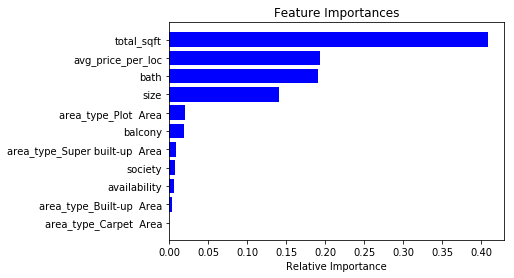

In [129]:
features = X_train.columns
importances = rf1_main.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### XGBoost

In [130]:
from xgboost import plot_importance

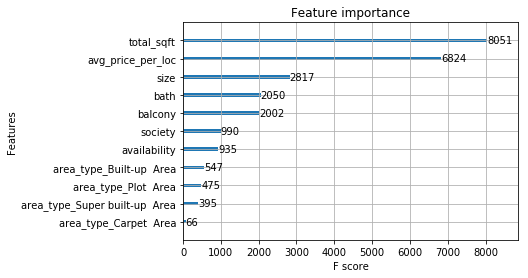

In [131]:
plot_importance(XG_Boost1)

## Recursive Feature Elimination

In [132]:
from sklearn.feature_selection import RFECV

### Random Forest

In [133]:
RFE = RFECV(rf1_main, step=3, cv=3, n_jobs=-1,
            scoring="neg_mean_squared_error", verbose=50)

RFE.fit(X=X_train, y=y_train)

RFECV(cv=3,
   estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=27,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=260, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
   n_jobs=-1, scoring='neg_mean_squared_error', step=3, verbose=50)

In [134]:
RFE.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [135]:
selected_feature_rf = dict(zip(X_train.columns,RFE.support_))

selected_rf = []
for k,v in selected_feature_rf.items():
    if (v==True):
        selected_rf.append(k)

In [136]:
selected_rf

['availability',
 'size',
 'society',
 'total_sqft',
 'bath',
 'balcony',
 'avg_price_per_loc',
 'area_type_Built-up  Area',
 'area_type_Carpet  Area',
 'area_type_Plot  Area',
 'area_type_Super built-up  Area']

This means that all the features are contributing to the model.

### XGBoost

In [137]:
RFE = RFECV(XG_Boost1, step=3, cv=3, n_jobs=-1,
            scoring="neg_mean_squared_error", verbose=50)

RFE.fit(X=X_train, y=y_train)

RFECV(cv=3,
   estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0.01,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=600,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.85, verbosity=1),
   n_jobs=-1, scoring='neg_mean_squared_error', step=3, verbose=50)

In [138]:
RFE.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [139]:
selected_feature_xgb = dict(zip(X_train.columns,RFE.support_))

selected_xgb = []
for k,v in selected_feature_xgb.items():
    if (v==True):
        selected_xgb.append(k)

In [140]:
selected_xgb

['availability',
 'size',
 'society',
 'total_sqft',
 'bath',
 'balcony',
 'avg_price_per_loc',
 'area_type_Built-up  Area',
 'area_type_Carpet  Area',
 'area_type_Plot  Area',
 'area_type_Super built-up  Area']

This means that all the features are contributing to the model.

# Final Results

Analyzing the results above, almost all models are giving similar rmse. We find that Random Forest model is performing best with least rmse of 0.292. So, we'll select the parameters of that model to train the final model to predict the test dataset.

In [144]:
RF = RandomForestRegressor(bootstrap=True,
                           criterion='mse',
                           max_depth=27,
                           max_features='sqrt',
                           max_leaf_nodes=None,
                           min_impurity_decrease=0.0,
                           min_impurity_split=None,
                           min_samples_leaf=1,
                           min_samples_split=5,
                           min_weight_fraction_leaf=0.0,
                           n_estimators=260,
                           n_jobs=1,
                           oob_score=False,
                           random_state=None,
                           verbose=0,
                           warm_start=False)

In [145]:
X_train = main_train.drop('price', axis=1)
y_train = main_train['price']

X_test = main_test.drop('price', axis=1)

In [146]:
RF.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=27,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=260, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [148]:
final_predictions = RF.predict(X_test)

In [155]:
pred_df = pd.DataFrame({'log_price': final_predictions})

pred_df['price'] = pred_df['log_price'].apply(lambda x: 2.71828**x)

pred_df.head()

,log_price,price
0,4.142000,62.928347
1,5.478141,239.400284
2,5.354329,211.521305
3,4.014180,55.377733
4,3.975499,53.276554


-----------------------------------------------------End-----------------------------------------------------